# Parcourir les rues de Paris

Algorithme de plus courts chemins dans un graphe. Calcul d'un chemin comparé au calcul de tous les chemins les plus courts.

In [1]:
%matplotlib inline

Cette idée vient d'une soirée Google Code initiée par Google et à laquelle des élèves de l'ENSAE ont participé. On dispose de la description des rues de Paris (qu'on considèrera comme des lignes droites). On veut déterminer le trajet de huit voitures de telle sorte qu'elles parcourent la ville le plus rapidement possible. On supposera deux cas :

- Les voitures peuvent être placées n'importe où dans la ville.
- Les voitures démarrent et reviennent au même point de départ, le même pour toutes.

Ce notebook décrit comment récupérer les données et propose une solution. Ce problème est plus connu sous le nom du [problème du postier chinois](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_postier_chinois) ou [Route inspection problem](https://en.wikipedia.org/wiki/Route_inspection_problem) pour lequel il existe un algorithme optimal à coût polynomial. Le problème n'est donc pas [NP complet](https://en.wikipedia.org/wiki/NP-completeness).

## Les données

On récupère les données sur Internet. Le paramètre `keep=200` garde seulement les 100 premières rues de Paris. Il faut remplacer cette valuer par `keep=-1` pour les garder toutes. Dans ce cas, l'exécution de ce notebook est longue. Les algorithmes ne sont pas nécessairement implémentés de façon très efficace.

In [2]:
import sys

sys.path.append("/home/xadupre/github/teachpyx")

In [3]:
from teachpyx.practice.rues_paris import get_data

url = "https://github.com/sdpython/teachpyx/raw/main/_data/paris_54000.zip"
edges, vertices = get_data(
    url, ".", verbose=True, keep=200
)  # keep=-1 pour toutes les rues
len(edges), len(vertices)

already downloaded './paris_54000.zip'


(200, 146)

Les noeuds sont simplement décrits par les coordonnées du carrefour.

In [4]:
vertices[:2]

[(48.873361200000005, 2.3236609), (48.8730454, 2.3235788)]

Les arcs sont des tuples comprenant :

* l'indice du premier carrefour
* l'indice du second carrefour
* si la rue est à double sens ou non
* les coordonnées du premier carrefour
* les coordonnées du second carrefour
* la distance entre les deux extrémités (la longueur de la rue)

In [5]:
edges[:2]

[(0,
  1,
  1,
  (48.873361200000005, 2.3236609),
  (48.8730454, 2.3235788),
  0.03562501840766763),
 (2,
  0,
  1,
  (48.8741849, 2.3239352),
  (48.873361200000005, 2.3236609),
  0.0937624742737696)]

Les carrefours sont les extrémités des rues ou noeuds (vertices) du graphe. Les rues sont les arcs (edges).
On trace sur un graphique un échantillon des carrefours. On suppose la ville de Paris suffisamment petite et loin des pôles pour considérer les coordonnées comme cartésiennes (et non comme longitude/latitude).

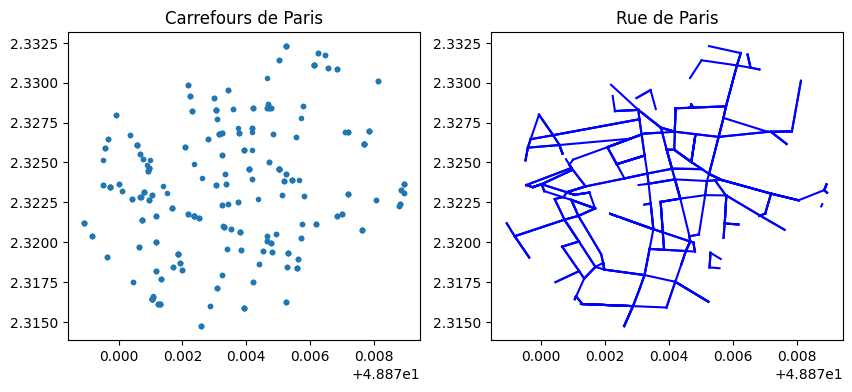

In [6]:
import matplotlib.pyplot as plt
import random

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sample = [vertices[random.randint(0, len(vertices) - 1)] for i in range(0, 500)]
ax[0].plot([_[0] for _ in sample], [_[1] for _ in sample], ".")
ax[0].set_title("Carrefours de Paris")

sample = [edges[random.randint(0, len(edges) - 1)] for i in range(0, 500)]
for edge in sample:
    ax[1].plot([edge[3][0], edge[4][0]], [edge[3][1], edge[4][1]], "b-")
ax[1].set_title("Rue de Paris");

Petite remarque : il n'y a pas de rues reliant un même carrefour à lui-même.

In [7]:
len(edges), len(list(e for e in edges if e[0] == e[1]))

(200, 0)

## Une première solution au premier problème

Ce problème est très similaire à celui du [portier chinois](http://fr.wikipedia.org/wiki/Probl%C3%A8me_du_postier_chinois). La solution qui suit n'est pas nécessaire la meilleure mais elle donne une idée de ce que peut-être une recherche un peu expérimentale sur le sujet.

Chaque noeud représente un carrefour et chaque rue est un arc reliant des deux carrefours. L'objectif est de parcourir tous les arcs du graphe avec 8 voitures. 

Premiere remarque, l'énoncé ne dit pas qu'il faut parcourir toutes les rues une seule fois. On conçoit aisément que ce serait l'idéal mais on ne sait pas si ce serait possible. Néanmoins, si une telle solution (un chemin passant une et une seule fois par toutes les rues) existe, elle est forcément optimale.

Deuxième remarque, les sens interdits rendent le problème plus complexe. On va dans un premier temps ne pas en tenir compte. On verra comment ajouter la contrainte par la suite et il y a aussi le problème des impasses. On peut néanmoins les contourner en les supprimant du graphe : il faut nécessairement faire demi-tour et il n'y a pas de meilleure solution.

Ces deux remarques étant faite, ce problème rappelle un peu le problème des sept ponts de [Konigsberg](http://fr.wikipedia.org/wiki/Probl%C3%A8me_des_sept_ponts_de_K%C3%B6nigsberg) : comment traverser passer par les sept de la ville une et une seule fois. Le mathématicien [Euler](http://fr.wikipedia.org/wiki/Leonhard_Euler) a répondu à cette question : c'est simple, il suffit que chaque noeud du graphe soit rejoint par un nombre pair de d'arc (= ponts) sauf au plus 2 (les noeuds de départ et d'arrivée). De cette façon, à chaque qu'on rejoint un noeud, il y a toujours une façon de repartir.

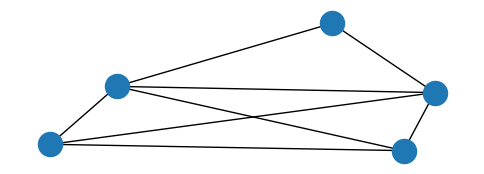

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
for i, j in [(1, 2), (1, 3), (1, 4), (2, 3), (3, 4), (4, 5), (5, 2), (2, 4)]:
    g.add_edge(i, j)
f, ax = plt.subplots(figsize=(6, 2))
nx.draw(g, ax=ax)

On ne peut pas trouver une chemin qui parcourt tous les arcs du graphe précédent une et une seule fois. Qu'en est-il du graphe de la ville de Paris ? On compte les noeuds qui ont un nombre pairs et impairs d'arcs les rejoignant (on appelle cela le [degré](http://fr.wikipedia.org/wiki/Degr%C3%A9_(th%C3%A9orie_des_graphes))).

In [9]:
nb_edge = {}
for edge in edges:
    v1, v2 = edge[:2]
    nb_edge[v1] = nb_edge.get(v1, 0) + 1
    nb_edge[v2] = nb_edge.get(v2, 0) + 1
parite = {}
for k, v in nb_edge.items():
    parite[v] = parite.get(v, 0) + 1

[sorted(parite.items())]

[[(1, 29), (2, 23), (3, 54), (4, 37), (5, 3)]]

On remarque que la plupart des carrefours sont le départ de 3 rues. Qu'à cela ne tienne, pourquoi ne pas ajouter des arcs entre des noeuds de degré impair jusqu'à ce qu'il n'y en ait plus que 2. De cette façon, il sera facile de construire un seul chemin parcourant toutes les rues. Comment ajouter ces arcs ? Cela va se faire en deux étapes :

- On utilise l'algorithme de [Bellman-Ford](http://fr.wikipedia.org/wiki/Algorithme_de_Bellman-Ford) pour construire une matrice des plus courts chemins entre tous les noeuds.
- On s'inspire de l'algorithme de poids minimal [Kruskal](http://fr.wikipedia.org/wiki/Algorithme_de_Kruskal). On trie les arcs par ordre croissant de distance. On ajoute ceux qui réduisent le nombre de noeuds de degré impairs en les prenant dans cet ordre.

**Quelques justifications :** le meilleur parcours ne pourra pas descendre en deça de la somme des distances des rues puisqu'il faut toutes les parcourir. De plus, s'il existe un chemin qui parcourt toutes les rues, en dédoublant toutes celles parcourues plus d'une fois, il est facile de rendre ce chemin *eulérien* dans un graphe légèrement modifié par rapport au graphe initial.

### Etape 1 : la matrice Bellman

Je ne détaillerai pas trop, la page Wikipedia est assez claire. La longueur de chaque rue est incluses dans la description de chaque arc. Elle peut être la distance cartésienne ou la une distance  de [Haversine](http://en.wikipedia.org/wiki/Haversine_formula) qui calcule la distance à la surface d'une sphère à partir des coordonnées géographiques. Paris est petit est une approximation cartésienne ne change pas grand chose.

Ensuite, on implémente l'algorithme de [Bellman-Ford](http://fr.wikipedia.org/wiki/Algorithme_de_Bellman-Ford).

In [10]:
import datetime

init = {(e[0], e[1]): e[-1] for e in edges}
init.update({(e[1], e[0]): e[-1] for e in edges})

edges_from = {}
for e in edges:
    if e[0] not in edges_from:
        edges_from[e[0]] = []
    if e[1] not in edges_from:
        edges_from[e[1]] = []
    edges_from[e[0]].append(e)
    edges_from[e[1]].append((e[1], e[0], e[2], e[4], e[3], e[5]))

modif = 1
total_possible_edges = len(edges_from) ** 2
it = 0
while modif > 0:
    modif = 0
    s = 0
    # on itère sur les clés connues au début de l'itération
    # il faut éviter d'itérer sur un ensemble et de le modifier en même temps
    keys = list(init)
    for i in keys:
        d = init[i]
        fromi2 = edges_from[i[1]]
        s += d
        for e in fromi2:
            if i[0] == e[1]:
                # on fait attention à ne pas ajouter de boucle sur le même noeud
                continue
            new_e = i[0], e[1]
            new_d = d + e[-1]
            if new_e not in init or init[new_e] > new_d:
                init[new_e] = new_d
                modif += 1
    print(
        f"{datetime.datetime.now()} iteration {it} modif {modif} # {len(init)}/{total_possible_edges}="
        f"{len(init)*100 / total_possible_edges:1.2f}%"
    )
    it += 1
    if it > 6:
        break

2023-08-19 09:10:56.535221 iteration 0 modif 778 # 1138/21316=5.34%
2023-08-19 09:10:56.538415 iteration 1 modif 1228 # 2258/21316=10.59%
2023-08-19 09:10:56.545218 iteration 2 modif 1717 # 3748/21316=17.58%
2023-08-19 09:10:56.557001 iteration 3 modif 2118 # 5500/21316=25.80%
2023-08-19 09:10:56.574194 iteration 4 modif 2442 # 7470/21316=35.04%
2023-08-19 09:10:56.602050 iteration 5 modif 2726 # 9624/21316=45.15%
2023-08-19 09:10:56.642132 iteration 6 modif 2900 # 11810/21316=55.40%


Avec 200 rues, c'est rapide mais cela peut être très long avec toutes les rues. On décide alors de ne considérer que les paires de noeuds pour lesquelles la distance à vol d'oiseau est inférieure au plus grand segment de rue ou inférieure à cette distance multipliée par un coefficient.

In [11]:
max_segment = max(e[-1] for e in edges)
max_segment

0.3258634178614415

On calcule les arcs admissibles (en espérant que les noeuds de degré impairs seront bien dedans). Cette étape peut être longue. C'est pour cela qu'on utilise le module [tqdm](https://github.com/tqdm/tqdm) pour afficher une barre de défilement.

In [12]:
from teachpyx.practice.rues_paris import distance_haversine as distance
from tqdm import tqdm


def build_possibles(vertices, edges, seuil):
    possibles = {(e[0], e[1]): e[-1] for e in edges}
    possibles.update({(e[1], e[0]): e[-1] for e in edges})
    for i1, v1 in tqdm(list(enumerate(vertices))):
        for i2 in range(i1 + 1, len(vertices)):
            v2 = vertices[i2]
            d = distance(v1[0], v1[1], v2[0], v2[1])
            if d < seuil:  # on ajuste le seuil
                possibles[i1, i2] = d
                possibles[i2, i1] = d
    return possibles


possibles = build_possibles(vertices, edges, max_segment)
print(
    f"original {len(edges)}/{total_possible_edges} = "
    f"{len(edges)/total_possible_edges}"
)
print(
    f"addition {len(possibles)-len(edges)}/{total_possible_edges} = "
    f"{(len(possibles)-len(edges))/total_possible_edges}"
)

100%|██████████| 146/146 [00:00<00:00, 2118.45it/s]

original 200/21316 = 0.009382623381497467
addition 5290/21316 = 0.248170388440608


On continue avec l'algorithme de [Bellman-Ford](http://fr.wikipedia.org/wiki/Algorithme_de_Bellman-Ford) modifié :

In [13]:
import datetime

init = {(e[0], e[1]): e[-1] for e in edges}
init.update({(e[1], e[0]): e[-1] for e in edges})

edges_from = {}
for e in edges:
    if e[0] not in edges_from:
        edges_from[e[0]] = []
    if e[1] not in edges_from:
        edges_from[e[1]] = []
    edges_from[e[0]].append(e)
    edges_from[e[1]].append((e[1], e[0], e[2], e[4], e[3], e[5]))

modif = 1
total_possible_edges = len(edges_from) ** 2
it = 0
while modif > 0:
    modif = 0
    initc = (
        init.copy()
    )  # to avoid RuntimeError: dictionary changed size during iteration
    s = 0
    for i, d in initc.items():
        if i not in possibles:
            continue  # we skip undesired edges ------------------- addition
        fromi2 = edges_from[i[1]]
        s += d
        for e in fromi2:
            if (
                i[0] == e[1]
            ):  # on fait attention à ne pas ajouter de boucle sur le même noeud
                continue
            new_e = i[0], e[1]
            new_d = d + e[-1]
            if new_e not in init or init[new_e] > new_d:
                init[new_e] = new_d
                modif += 1
    print(
        f"{datetime.datetime.now()} iteration {it} modif {modif} "
        f"# {len(initc)}/{total_possible_edges}="
        f"{len(initc)*100 / total_possible_edges:1.2f}%"
    )
    it += 1
    if it > 20:
        break

2023-08-19 09:10:56.912505 iteration 0 modif 778 # 400/21316=1.88%
2023-08-19 09:10:56.928070 iteration 1 modif 1213 # 1138/21316=5.34%
2023-08-19 09:10:56.938916 iteration 2 modif 1627 # 2244/21316=10.53%
2023-08-19 09:10:56.957763 iteration 3 modif 1676 # 3644/21316=17.10%
2023-08-19 09:10:56.976823 iteration 4 modif 1341 # 4989/21316=23.40%
2023-08-19 09:10:57.020697 iteration 5 modif 833 # 5977/21316=28.04%
2023-08-19 09:10:57.042415 iteration 6 modif 427 # 6489/21316=30.44%
2023-08-19 09:10:57.062800 iteration 7 modif 187 # 6716/21316=31.51%
2023-08-19 09:10:57.088837 iteration 8 modif 74 # 6815/21316=31.97%
2023-08-19 09:10:57.112715 iteration 9 modif 36 # 6856/21316=32.16%
2023-08-19 09:10:57.138552 iteration 10 modif 9 # 6874/21316=32.25%
2023-08-19 09:10:57.168428 iteration 11 modif 1 # 6874/21316=32.25%
2023-08-19 09:10:57.197202 iteration 12 modif 0 # 6874/21316=32.25%


L'algorithme consiste à regarder les chemins $a \rightarrow b \rightarrow c$ et à comparer s'il est plus rapide que $a \rightarrow c$. 

In [14]:
original = {(e[0], e[1]): e[-1] for e in edges}
original.update({(e[1], e[0]): e[-1] for e in edges})
additions = {k: v for k, v in init.items() if k not in original}
additions.update({(k[1], k[0]): v for k, v in additions.items()})

### Kruskall

On trie les arcs par distance croissante, on enlève les arcs qui ne relient pas des noeuds de degré impair puis on les ajoute un par jusqu'à ce qu'il n'y ait plus d'arc de degré impair.

In [15]:
degre = {}
for k, v in original.items():  # original est symétrique
    degre[k[0]] = degre.get(k[0], 0) + 1

tri = [
    (v, k)
    for k, v in additions.items()
    if degre[k[0]] % 2 == 1 and degre[k[1]] % 2 == 1
]
tri.extend(
    [
        (v, k)
        for k, v in original.items()
        if degre[k[0]] % 2 == 1 and degre[k[1]] % 2 == 1
    ]
)
tri.sort()

impairs = sum(v % 2 for k, v in degre.items())

added_edges = []

for v, a in tri:
    if degre[a[0]] % 2 == 1 and degre[a[1]] % 2 == 1:
        # il faut refaire le test car degre peut changer à chaque itération
        degre[a[0]] += 1
        degre[a[1]] += 1
        added_edges.append(a + (v,))
        impairs -= 2
        if impairs <= 0:
            break

# on vérifie
print(f"nb degré impairs {impairs} nombre d'arcs ajoutés {len(added_edges)}")
print(f"longueur ajoutée {sum( v for a,b,v in added_edges )}")
print(f"longueur initiale {sum( e[-1] for e in edges )}")

nb degré impairs 2 nombre d'arcs ajoutés 42
longueur ajoutée 5.122002169199727
longueur initiale 15.661698849016764


Le nombre de noeuds impairs obtenus à la fin doit être inférieur à 2 pour être sûr de trouver un chemin (mais on choisira 0 pour avoir un circuit eulérien). Mon premier essai n'a pas donné satisfaction car j'avais choisi un seuil trop petit lors de la sélection des arcs à ajouter. J'ai augmenté le seuil par la suite. S'il reste encore des noeuds de degré impairs, on a le choix entre augmenter ce seuil - mais l'algorithme est déjà long - ou chercher dans une autre direction comme laisser l'algorithme de Bellman explorer les noeuds de degré impairs. Ca ne veut pas forcément dire qu'il manque des arcs mais que peut-être ils sont mal choisis. Si l'arc $i \rightarrow j$ est choisi, l'arc $j \rightarrow k$ ne le sera pas car $j$ aura un degré pair. Mais dans ce cas, si l'arc $j \rightarrow k$ était le dernier arc disponible pour combler $k$, on est coincé. On peut augmenter le seuil encore mais cela risquee de prendre du temps et puis cela ne fonctionnerait pas toujours sur tous les jeux de données.

On pourait alors écrire une sorte d'algorithme itératif qui exécute l'algorithme de Bellman, puis lance celui qui ajoute les arcs. Puis on revient au premier en ajoutant plus d'arcs autour des noeuds problèmatique lors de la seconde étape. L'ensemble est un peu long pour tenir dans un notebook mais le code est celui de la fonction [eulerien_extension](https://github.com/sdpython/teachpyx/blob/main/teachpyx/practice/rues_paris.py#L313). Je conseille également la lecture de cet article : [Efficient Algorithms for Eulerian Extension](https://fpt.akt.tu-berlin.de/publications/Eulerian_Extension_and_Rural_Postman_SIDMA.pdf) (voir également [On Making Directed Graphs Eulerian](http://arxiv.org/abs/1101.4283)). L'exécution qui suit prend une vingtaine de minutes.

### Chemin Eulérien

A cet instant, on n'a pas vraiment besoin de connaître la longueur du chemin eulérien passant par tous les arcs. Il s'agit de la somme des arcs initiaux et ajoutés (soit environ 334 + 1511). On suppose qu'il n'y qu'une composante connexe. Construire le chemin eulérien fait apparaître quelques difficultés comme la suivante : on parcourt le graphe dans un sens mais on peut laisser de côté une partie du chemin et créer une seconde composante connexe.

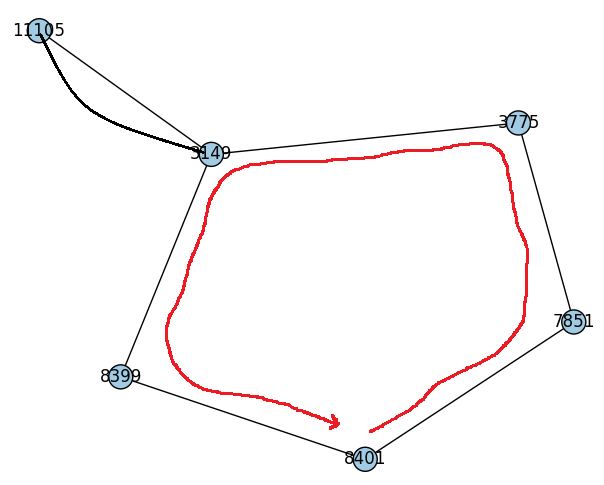

In [16]:
from IPython.display import Image

Image("euler.png", width=400)

Quelques algorithmes sont disponibles sur cette page [Eulerian_path](http://en.wikipedia.org/wiki/Eulerian_path). L'algorithme de Hierholzer consiste à commencer un chemin eulérien qui peut revenir au premier avant d'avoir tout parcouru. Dans ce cas, on parcourt les noeuds du graphe pour trouver un noeud qui repart ailleurs et qui revient au même noeud. On insert cette boucle dans le chemin initial. Tout d'abord, on construit une structure qui pour chaque noeud associe les noeuds suivant. La fonction [euler_path](https://github.com/sdpython/teachpyx/blob/main/teachpyx/practice/rues_paris.py#L390)

In [17]:
from teachpyx.practice.rues_paris import euler_path, eulerien_extension

added = eulerien_extension(edges, verbose=True)
added[:5]

------- nb odd vertices 10 iteration 0
iteration 0 #modif 113 # 1327/10585 = 12.54%
iteration 1 #modif 90 # 1383/10585 = 13.07%
iteration 2 #modif 113 # 1423/10585 = 13.45%
iteration 3 #modif 133 # 1470/10585 = 13.89%
iteration 4 #modif 168 # 1523/10585 = 14.39%
iteration 5 #modif 187 # 1589/10585 = 15.01%
iteration 6 #modif 192 # 1655/10585 = 15.64%
iteration 7 #modif 219 # 1722/10585 = 16.27%
iteration 8 #modif 232 # 1796/10585 = 16.97%
iteration 9 #modif 227 # 1863/10585 = 17.61%
iteration 10 #modif 207 # 1919/10585 = 18.13%
iteration 11 #modif 164 # 1968/10585 = 18.59%
iteration 12 #modif 111 # 2003/10585 = 18.92%
iteration 13 #modif 77 # 2027/10585 = 19.15%
iteration 14 #modif 43 # 2038/10585 = 19.25%
iteration 15 #modif 13 # 2039/10585 = 19.27%
iteration 16 #modif 2 # 2040/10585 = 19.27%
iteration 17 #modif 0 # 2040/10585 = 19.27%


[(22, 31, 0.0016168196457467584),
 (48, 55, 0.002915457386378182),
 (26, 45, 0.004107201738406607),
 (109, 138, 0.005201454147672404),
 (29, 73, 0.010775423696863674)]

In [18]:
path = euler_path(edges, added)
path[:5]

[(43, ['street', 43, 59, 0.016229655482986917]),
 (74, ['street', 74, 43, 0.08264740074165475]),
 (36, ['street', 36, 74, 0.026299568900906643]),
 (74, ['jump', 36, 74, 0.026299568900906643]),
 (53, ['street', 74, 53, 0.08193964999861593])]

Le label ``street`` signifie que l'arête provient de l'ensemble des rues, le label ``jump`` signifie que c'est une arête ajoutée. Pour couper le parcours en 8 (8 voitures), il suffit de couper le chemin en 8 parts presque égales en trouvant 8 arêtes ``jump`` presque également réparties le long du chemin eulérien. On peut bien évidemment couper à une arête ``street`` mais celle-là devra faire partie d'un des deux ensembles pas l'arête ``jump`` qui peut être jetée. On peut envisager une approche dichotomique. Couper en deux, recouper en deux chaque intervalle et minimiser sur la meilleur arête ``jump`` du début.

Il reste maintenant à prendre en compte les sens interdits. Cette modification peut intervenir à deux endroits :

* Soit le nombre de sens interdit est faible et on peut s'en dépatouiller en parcourant le plus possible des rues dans le bon sens, en choisissant le plus les arcs dans le bon sens lors de la création du chemin eulérien.
* Soit on crée un graphe eulérien orienté (pour chaque noeud, les nombres d'arêtes sortantes et entrantes sont égaux, voir [Euler Circuit in a Directed Graph](http://www.geeksforgeeks.org/euler-circuit-directed-graph/)).

Dans le cas où on souhaite que les voitures partent toutes du même point et reviennent à ce même point, la solution précédente fournira une borne supérieure (il suffit d'ajouter des arêtes ``jump`` pour amener et ramener les voitures).

## Algorithme optimal

La variante de l'algorithme de [Kruskal](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) propose une solution approchée pour apparier les noeuds de degré impair. On cherche à minimiser la somme des distances entre les noeuds apparier. Il existe un algorithme optimal pour résoudre ce problème : l'[algorithme d'Edmonds pour les couplages](https://en.wikipedia.org/wiki/Blossom_algorithm).

## Variantes

### Sens interdit et gaphe orienté

Si la ville contient des sens interdits, c'est comme si le graphe était orienté. Chaque arc ne peut être parcouru que dans un sens. Il faut alors distinguer les degrés entrants et sortants de chaque noeud. Il faut s'assurer pour chaque noeud que le nombre d'arc entrant et sortant sont identiques. Si ce n'est pas le cas, on se sert de l'algorithme d'appariement pour recréer des arcs.

### Windy postman problem

C'est une variante pour laquelle le coût d'un arc n'est pas le même selon qu'on le parcourt dans un sens ou dans l'autre (à contre sens). Ce problème est [NP complet](https://en.wikipedia.org/wiki/NP-completeness).